## Define project parameters

In [51]:
import pathlib

worker_image = 'us-east4-docker.pkg.dev/catx-x-taara/radlab-silicon-tuning-containers/silicon-design-ubuntu-2004'
staging_bucket = 'catx-x-taara-radlab-silicon-tuning-staging'
project = 'catx-x-taara'
location = 'us-east4'
machine_type = 'n1-standard-8'
notebook = 'mmi.ipynb'
prefix = pathlib.Path(notebook).stem
staging_dir = f'{prefix}-tuning_2'

## Delete data from previous runs and stage the notebook for the experiment

In [ ]:
!rm -r {staging_dir}
!gsutil -m rm -r gs://{staging_bucket}/{staging_dir}/
!gsutil cp {notebook} gs://{staging_bucket}/{staging_dir}/{notebook}

## Create Parameters and Metrics specs

We want to find the best value for *target density* and *die area* in order optimize *total power* consumption.

Those keys map to the [parameters](https://papermill.readthedocs.io/en/latest/usage-parameterize.html) and [metrics](https://github.com/GoogleCloudPlatform/cloudml-hypertune) advertised by the notebook.

In [53]:
from google.cloud.aiplatform import hyperparameter_tuning as hpt

parameter_spec = {
    'width_mmi': hpt.DoubleParameterSpec(min=3, max=10, scale='linear'),
    'length_mmi': hpt.DoubleParameterSpec(min=5, max=17, scale='linear'),
    'gap_mmi': hpt.DoubleParameterSpec(min=.5, max=2, scale='linear'),
    'width_taper': hpt.DoubleParameterSpec(min=1, max=2, scale='linear'),
}

metric_spec={'transmission_1550': 'maximize'}

## Create Custom Job spec

In [54]:
from google.cloud import aiplatform
import pathlib

worker_pool_specs = [{
    'machine_spec': {
        'machine_type': machine_type,
    },
    'replica_count': 1,
    'container_spec': {
        'image_uri': worker_image,
        'args': ['/usr/local/bin/papermill-launcher', 
                 f'gs://{staging_bucket}/{staging_dir}/{notebook}',
                 f'$AIP_MODEL_DIR/{prefix}_out.ipynb',
                 '--run_dir=/tmp']
    }
}]
custom_job = aiplatform.CustomJob(display_name=f'{prefix}-custom-job',
                                  worker_pool_specs=worker_pool_specs,
                                  staging_bucket=staging_bucket,
                                  base_output_dir=f'gs://{staging_bucket}/{staging_dir}')

## Run Hyperparameter tuning job

In [ ]:
from google.cloud import aiplatform

parameters_count = len(parameter_spec.keys())
metrics_count = len(metric_spec.keys())
max_trial_count = 100 * parameters_count * metrics_count
parallel_trial_count = 20

hpt_job = aiplatform.HyperparameterTuningJob(
    display_name=f'{prefix}-tuning-job',
    custom_job=custom_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=max_trial_count,
    parallel_trial_count=parallel_trial_count,
    max_failed_trial_count=max_trial_count,
    location=location)
hpt_job.run(sync=True)

Creating HyperparameterTuningJob
HyperparameterTuningJob created. Resource name: projects/91169090807/locations/us-east4/hyperparameterTuningJobs/5383503598707539968
To use this HyperparameterTuningJob in another session:
hpt_job = aiplatform.HyperparameterTuningJob.get('projects/91169090807/locations/us-east4/hyperparameterTuningJobs/5383503598707539968')
View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/us-east4/training/5383503598707539968?project=91169090807
HyperparameterTuningJob projects/91169090807/locations/us-east4/hyperparameterTuningJobs/5383503598707539968 current state:
JobState.JOB_STATE_PENDING
HyperparameterTuningJob projects/91169090807/locations/us-east4/hyperparameterTuningJobs/5383503598707539968 current state:
JobState.JOB_STATE_RUNNING
HyperparameterTuningJob projects/91169090807/locations/us-east4/hyperparameterTuningJobs/5383503598707539968 current state:
JobState.JOB_STATE_RUNNING
HyperparameterTuningJob projects/91169090807/

## Check the current state

In [49]:
[(job.display_name, job.done(), job.state) for job in aiplatform.HyperparameterTuningJob.list(filter=f'display_name={prefix}-tuning-job') if not job.done()]

[]

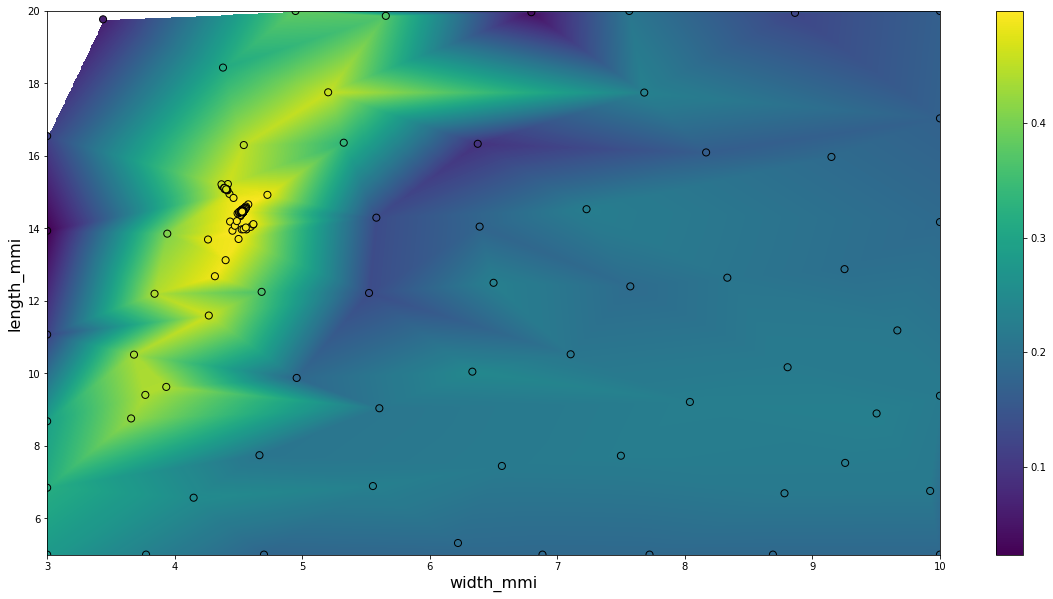

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = df['width_mmi'].to_numpy()
y = df['length_mmi'].to_numpy()
z = df['transmission_1550'].to_numpy()

# target grid to interpolate to
xi = np.linspace(x.min(),x.max(),1000)
yi = np.linspace(y.min(),y.max(),1000)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='linear')

# plot
fig = plt.figure(figsize=(20,10))
#plt.contourf(xi,yi,zi, levels=100)
plt.imshow(zi, extent=([x.min(),x.max(),y.min(),y.max()]), origin='lower', aspect='auto')
plt.scatter(x,y,s=50,c=z,edgecolor='black')
plt.xlabel('width_mmi',fontsize=16)
plt.ylabel('length_mmi',fontsize=16)
plt.colorbar()